# Load the data

In [3]:
import pandas as pd
in_datafile = "in/ttj.csv" # Large output file 
in_datafile = "in/ttj_mini.csv" 
df = pd.read_csv(in_datafile)
df.head()

,parton_t_lep_Px,parton_t_lep_Py,parton_t_lep_Pz,parton_t_lep_E,parton_t_had_Px,parton_t_had_Py,parton_t_had_Pz,parton_t_had_E,parton_W_had_Px,parton_W_had_Py,...,b_lep_Pz,b_lep_E,b_had_Px,b_had_Py,b_had_Pz,b_had_E,W_lep_Px,W_lep_Py,W_lep_Pz,W_lep_E
0,115953.309657,-19531.682371,1.143977e+06,1.161797e+06,-112352.015957,14328.658820,200153.510060,286474.991614,-84408.843139,-51084.526105,...,-220285.857070,235152.312500,-38670.694399,-44636.538914,28285.945621,66052.390625,-53877.458962,-3008.988417,6772.140504,97065.419607
1,-102694.660940,78131.849125,-7.190671e+04,2.272455e+05,79646.220464,-44673.744951,235472.471490,303690.130424,119020.236909,-20739.264197,...,51778.306598,114941.757812,-58513.827960,-59645.477767,67356.047204,107864.656250,26482.636012,-5712.530661,35780.862333,109663.780917
2,55461.180815,-40178.135967,3.740767e+04,1.890468e+05,-30416.788942,64111.268529,-340124.129835,388033.158287,-55224.762545,-11727.798770,...,78858.696257,94450.312500,-18280.594683,-43006.725900,-11653.870701,48453.332031,62927.295092,62517.872352,70107.181716,138946.006506
3,40169.992304,-82225.731691,2.458733e+05,3.144584e+05,-21801.892252,11872.892914,527817.684859,555776.934684,-41738.570399,-47258.555612,...,28424.925697,54106.617188,-25431.470674,-60022.528520,19957.287169,69209.710938,-184563.380908,111826.823172,150376.575066,279474.396026
4,-138971.235265,-19525.738077,-1.893818e+05,3.262344e+05,166580.268823,-20557.015938,53280.955992,246221.186813,40120.661794,11097.899201,...,-64280.284562,78087.148438,-33022.619908,-23193.606409,52196.985281,66278.523438,19279.118514,-77724.220949,211457.935764,239981.659156


In [4]:
fraction_train = 0.65 
max_size = len(df)
train_df = df[:int(max_size*fraction_train)]
test_df  = df[int(max_size*fraction_train):max_size]
print "Created train dataframe of size: ", len(train_df)
print "Created test dataframe of size:  ", len(test_df)

Created train dataframe of size:  206662
Created test dataframe of size:   111280


### Create input X and Y vectors

Set-up the input and output vectors. 

The output vector is going to be the jet indices:
    ( 
    
        is_fisrt_bjet_leptonic
        is_second_bjet_hadronic,
        is_in_W
        is_in_W,
        is_in_W,
    )
Then some spectator variables needed for the custom loss function that minimizes differences in four momenta: 
    (
    
        parton_top_had_p4,
        parton_top_lep_p4,
        parton_w_had_p4,
        reco_w_lep_p4,
        reco_bjet_1
        reco_bjet_2
        reco_jet_1
        reco_jet_2
        reco_jet_3     
    )
    

In [76]:
import numpy as np
"""
jet_1       
jet_2       
jet_3       
bjet_1      
bjet_2      
t_lep_truth 
t_had_truth 
w_had_truth
w_lep_truth 
"""
all_variables = list(df.columns.values)
reco_variables = all_variables[12:24]+all_variables[32:40]
# parton_variables = all_variables[0:12]+all_variables[24:32]+all_variables[40:44]
parton_variables = all_variables[0:12]+all_variables[40:44]

jet_input_train   =train_df[reco_variables].values
Y_train = truth_input_train = train_df[reco_variables+parton_variables].values
jet_input_test   =test_df[reco_variables].values
Y_test = truth_input_test = test_df[reco_variables+parton_variables].values

# Add the dummy assignment vectors 
# A
for i in xrange(3):
    Y_train =  np.insert(Y_train, len(Y_train[0]),0, axis=1)
    Y_test =  np.insert(Y_test, len(Y_test[0]),0, axis=1)



print jet_input_train.shape
print truth_input_train.shape
print Y_train.shape

(206662, 20)
(206662, 36)
(206662, 39)


# Basic plots

# Set-up the model

In [83]:
import ROOT as r 
from keras import backend as K

def transform_to_jet_assignment(y_pred):
    """
        Convert a 3-vector that sums to unity into a vector of 3 predictions
        where:
            first element represents  if jet_1 is in the  hadronic W
            second element represents if jet_2 is in the  hadronic W
            third element represents  if bjet_1 is in the hadronic top
            
            The jet_3 is therefore in the hadronic_W when (2 - [0]-[1] ) == 1
            The bjet_2 is therefore in the hadronic_W when (1 - [2] ) == 1
    """
#     y_pred[:,K.argmax(y_pred[:,:2])]  = 1.0
#     y_pred[:,K.argmin(y_pred[:,1:3])] = 1.0
    y_pred[:,K.argmin(y_pred[:,:3])]  *= 0.0
    return y_pred

def mass_diff_loss(y_true,y_pred):
    """
        user defined evaluation function, return a pair (metric_name, result)        
        See the following links for details 
            https://github.com/keras-team/keras/issues/4781
            https://stackoverflow.com/questions/45961428/make-a-custom-loss-function-in-keras
        
        
        Intended to be used with 16 so-called spectator variables that correspond to
        the truth level leptonic and hadronic top, truth level hadronic W, and reconstucted
        leptonic W boson four momemtum
        
        A further 20 spectator variables are passed that correspond to the reconstruction level
        jets, 3 light jets and 2 b-jets. 
        
        The only part of y_pred that effects this loss function is the last 3 elements. These 
        correspond to jet assignment. 
    """
    # Note everything is done by tensor algebra - so this actually working things out for
    # every event in a batch all in one go using a highly optimized tensorflow backend
        
    # Transform predictions into booleans that represent
    # if a jet is a decay product of the hadronic top quark 
    assignment = y_pred[:,:3]#transform_to_jet_assignment(y_pred) 

    # Get the four vectors for each of the needed physics objects
    # we're in a basis such that each four vector = (px,py,pz,E)
    jet_1        = y_true[:,0:4]/1e3
    jet_2        = y_true[:,4:8]/1e3
    jet_3        = y_true[:,8:12]/1e3
    bjet_1       = y_true[:,12:16]/1e3
    bjet_2       = y_true[:,16:20]/1e3
    t_lep_truth  = y_true[:,20:24]/1e3
    t_had_truth  = y_true[:,24:28]/1e3
    w_had_truth  = y_true[:,28:32]/1e3
    w_lep_truth  = y_true[:,32:36]/1e3

    # calculated the masses for all of the predictions and truth level objects
    top_hadronic_px  = assignment[:,0]*jet_1[:,0] + assignment[:,1]*jet_2[:,0] + (2-assignment[:,1])*jet_3[:,0] + assignment[:,2]*bjet_1[:,0]+ (1-assignment[:,2])*bjet_2[:,0]
    top_hadronic_py  = assignment[:,0]*jet_1[:,1] + assignment[:,1]*jet_2[:,1] + (2-assignment[:,1])*jet_3[:,1] + assignment[:,2]*bjet_1[:,1]+ (1-assignment[:,2])*bjet_2[:,1]
    top_hadronic_pz  = assignment[:,0]*jet_1[:,2] + assignment[:,1]*jet_2[:,2] + (2-assignment[:,1])*jet_3[:,2] + assignment[:,2]*bjet_1[:,2]+ (1-assignment[:,2])*bjet_2[:,2]
    top_hadronic_e   = assignment[:,0]*jet_1[:,3] + assignment[:,1]*jet_2[:,3] + (2-assignment[:,1])*jet_3[:,3] + assignment[:,2]*bjet_1[:,3]+ (1-assignment[:,2])*bjet_2[:,3]    
    top_hadronic_m   = K.sqrt(K.abs(-K.square(top_hadronic_e)+K.square(top_hadronic_px)+K.square(top_hadronic_py)+K.square(top_hadronic_py)))

    w_hadronic_px  = assignment[:,0]*jet_1[:,0] + assignment[:,1]*jet_2[:,0]  + (2-assignment[:,1])*jet_3[:,0]
    w_hadronic_py  = assignment[:,0]*jet_1[:,1] + assignment[:,1]*jet_2[:,1]  + (2-assignment[:,1])*jet_3[:,1]
    w_hadronic_pz  = assignment[:,0]*jet_1[:,2] + assignment[:,1]*jet_2[:,2]  + (2-assignment[:,1])*jet_3[:,2]
    w_hadronic_e   = assignment[:,0]*jet_1[:,3] + assignment[:,1]*jet_2[:,3]  + (2-assignment[:,1])*jet_3[:,3]
    w_hadronic_m   = K.sqrt(K.abs(-K.square(w_hadronic_e) + K.square(w_hadronic_px)+K.square(w_hadronic_py)+K.square(w_hadronic_pz)))
    
    t_lep_truth_m   = K.abs(-K.square(t_lep_truth[:,3]) + K.square(t_lep_truth[:,0]) + K.square(t_lep_truth[:,1]) + K.square(t_lep_truth[:,2]))
    t_had_truth_m   = K.abs(-K.square(t_had_truth[:,3]) + K.square(t_had_truth[:,0]) + K.square(t_had_truth[:,1]) + K.square(t_had_truth[:,2]))
    w_had_truth_m   = K.abs(-K.square(w_had_truth[:,3]) + K.square(w_had_truth[:,0]) + K.square(w_had_truth[:,1]) + K.square(w_had_truth[:,2]))
#     w_lep_truth_m   = K.sqrt(K.abs(-K.square(w_lep_truth[:,3]) + K.square(w_lep_truth[:,0]) + K.square(w_lep_truth[:,1]) + K.square(w_lep_truth[:,2])))

    top_lep_pz = w_lep_truth[:,0] + (1-assignment[:,2])*bjet_1[:,0]+ (assignment[:,2])*bjet_2[:,0]
    top_lep_py = w_lep_truth[:,1] + (1-assignment[:,2])*bjet_1[:,1]+ (assignment[:,2])*bjet_2[:,1]
    top_lep_px = w_lep_truth[:,2] + (1-assignment[:,2])*bjet_1[:,2]+ (assignment[:,2])*bjet_2[:,2]
    top_lep_e  = w_lep_truth[:,3] + (1-assignment[:,2])*bjet_1[:,3]+ (assignment[:,2])*bjet_2[:,3]
    top_lep_m  = K.sqrt(K.abs(-K.square(top_lep_e) + (K.square(top_lep_px)+K.square(top_lep_py)+K.square(top_lep_pz))))
    
    # Return the loss as the differences in mass for each of the reconstructed objects 
    return  K.square(w_had_truth_m)#K.abs(w_hadronic_m - w_had_truth_m)#w_lep_truth[:,3] #w_hadronic_m  )#K.square(top_lep_m-t_lep_truth_m) + K.square(top_hadronic_m-t_had_truth_m)+K.square(w_hadronic_m-w_had_truth_m)


In [84]:
from keras.layers import Input, Dense,Concatenate,concatenate, Dropout
from keras.models import Model
from keras.utils import plot_model

# Construct the jet assignment part of the network, a simple MLP
jet_assignment_input  = Input(shape=(20,), dtype='float32', name='RecoJetInput')
jet_assignment_hidden = Dense(32, activation='relu', name='JetAssignmentLayer')(jet_assignment_input)
jet_assignment_dropout = Dropout(32, name='JetAssignmentDropoutLayer')(jet_assignment_hidden)
jet_assignment_output = Dense(3,  activation='softmax', name='JetAssignment2ndLayer')(jet_assignment_dropout)

# Merge in truth level information required for the 
auxiliary_input = Input(shape=(36,), name='TruthLevelInput')
total_model = concatenate([ auxiliary_input,jet_assignment_output], name='Combination')

# And finally we add the main logistic regression layer
# output = Dense(3, activation='sigmoid', name='Output')(x)

model = Model(inputs=[jet_assignment_input,auxiliary_input], outputs=[total_model])
model.compile(optimizer='rmsprop', loss=mass_diff_loss)
model.summary()
plot_model(model, to_file='model.png',show_shapes=True)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
RecoJetInput (InputLayer)        (None, 20)            0                                            
____________________________________________________________________________________________________
JetAssignmentLayer (Dense)       (None, 32)            672         RecoJetInput[0][0]               
____________________________________________________________________________________________________
JetAssignmentDropoutLayer (Dropo (None, 32)            0           JetAssignmentLayer[0][0]         
____________________________________________________________________________________________________
TruthLevelInput (InputLayer)     (None, 36)            0                                            
___________________________________________________________________________________________

# Train the model

In [85]:
losses = model.fit( [jet_input_train,truth_input_train],
          Y_train, 
#           validation_split = 0.1,
#           batch_size=59,
          epochs = 3
         )

ValueError: Tried to convert 'x' to a tensor and failed. Error: None values not supported.

In [88]:
import matplotlib.pyplot as plt 

train_loss =  losses.history['loss']        
epochs = np.linspace(0,len(losses.history['loss'])-1,len(losses.history['loss']))

# plt.plot(epochs,train_loss)
val_loss =  losses.history['val_loss']        
plt.plot(epochs,val_loss)


plt.show()

KeyError: 'val_loss'

In [87]:
# Make a prediction basd upon this trained model 
test_pred = model.predict([jet_input_test,truth_input_test])
test_assignments = test_pred[:,-3:]
# test_assignments[:,2:3]

# Construct the physics objects and plot variables of interest

In [98]:
import ROOT as r 

def construct_top_kinematics(assignment, Y_test):
    jet_1        = Y_test[:,0:4]/1e3
    jet_2        = Y_test[:,4:8]/1e3
    jet_3        = Y_test[:,8:12]/1e3
    bjet_1       = Y_test[:,12:16]/1e3
    bjet_2       = Y_test[:,16:20]/1e3
    t_lep_truth  = Y_test[:,20:24]/1e3
    t_had_truth  = Y_test[:,24:28]/1e3
    w_had_truth  = Y_test[:,28:32]/1e3
    w_lep_truth  = Y_test[:,32:36]/1e3
    
    top_hadronic_px  = assignment[:,0]*jet_1[:,0] + assignment[:,1]*jet_2[:,0] + (2-assignment[:,1])*jet_3[:,0] + assignment[:,2]*bjet_1[:,0]+ (1-assignment[:,2])*bjet_2[:,0]
    top_hadronic_py  = assignment[:,0]*jet_1[:,1] + assignment[:,1]*jet_2[:,1] + (2-assignment[:,1])*jet_3[:,1] + assignment[:,2]*bjet_1[:,1]+ (1-assignment[:,2])*bjet_2[:,1]
    top_hadronic_pz  = assignment[:,0]*jet_1[:,2] + assignment[:,1]*jet_2[:,2] + (2-assignment[:,1])*jet_3[:,2] + assignment[:,2]*bjet_1[:,2]+ (1-assignment[:,2])*bjet_2[:,2]
    top_hadronic_e   = assignment[:,0]*jet_1[:,3] + assignment[:,1]*jet_2[:,3] + (2-assignment[:,1])*jet_3[:,3] + assignment[:,2]*bjet_1[:,3]+ (1-assignment[:,2])*bjet_2[:,3]    
    top_hadronic_m   = K.sqrt(K.abs(-K.square(top_hadronic_e)+K.square(top_hadronic_px)+K.square(top_hadronic_py)+K.square(top_hadronic_py)))

    w_hadronic_px  = assignment[:,0]*jet_1[:,0] + assignment[:,1]*jet_2[:,0]  + (2-assignment[:,1])*jet_3[:,0]
    w_hadronic_py  = assignment[:,0]*jet_1[:,1] + assignment[:,1]*jet_2[:,1]  + (2-assignment[:,1])*jet_3[:,1]
    w_hadronic_pz  = assignment[:,0]*jet_1[:,2] + assignment[:,1]*jet_2[:,2]  + (2-assignment[:,1])*jet_3[:,2]
    w_hadronic_e   = assignment[:,0]*jet_1[:,3] + assignment[:,1]*jet_2[:,3]  + (2-assignment[:,1])*jet_3[:,3]
    w_hadronic_m   = K.sqrt(K.abs(-K.square(w_hadronic_e) + K.square(w_hadronic_px)+K.square(w_hadronic_py)+K.square(w_hadronic_pz)))
    
    t_lep_truth_m   = K.sqrt(K.abs(-K.square(t_lep_truth[:,3]) + K.square(t_lep_truth[:,0]) + K.square(t_lep_truth[:,1]) + K.square(t_lep_truth[:,2])))
    t_had_truth_m   = K.sqrt(K.abs(-K.square(t_had_truth[:,3]) + K.square(t_had_truth[:,0]) + K.square(t_had_truth[:,1]) + K.square(t_had_truth[:,2])))
    w_had_truth_m   = K.sqrt(K.abs(-K.square(w_had_truth[:,3]) + K.square(w_had_truth[:,0]) + K.square(w_had_truth[:,1]) + K.square(w_had_truth[:,2])))
    w_lep_truth_m   = K.sqrt(K.abs(-K.square(w_lep_truth[:,3]) + K.square(w_lep_truth[:,0]) + K.square(w_lep_truth[:,1]) + K.square(w_lep_truth[:,2])))

    top_lep_pz = w_lep_truth[:,0] + (1-assignment[:,2])*bjet_1[:,0]+ (assignment[:,2])*bjet_2[:,0]
    top_lep_py = w_lep_truth[:,1] + (1-assignment[:,2])*bjet_1[:,1]+ (assignment[:,2])*bjet_2[:,1]
    top_lep_px = w_lep_truth[:,2] + (1-assignment[:,2])*bjet_1[:,2]+ (assignment[:,2])*bjet_2[:,2]
    top_lep_e  = w_lep_truth[:,3] + (1-assignment[:,2])*bjet_1[:,3]+ (assignment[:,2])*bjet_2[:,3]
    
    
    top_hads = []
    for  px,py,pz,e in zip( top_hadronic_px, top_hadronic_py, top_hadronic_pz, top_hadronic_e  ):
        top_had = r.TLorentzVector()
        top_had.SetPxPyPzE( px,
                            py,
                            pz,
                            e 
                          )
        top_hads.append(top_had)
           
    top_leps = []
    for  px,py,pz,e in zip( top_lep_px, top_lep_py, top_lep_pz, top_lep_e  ):
        top_lep = r.TLorentzVector()
        top_lep.SetPxPyPzE( px,
                            py,
                            pz,
                            e 
                          )
        top_leps.append(top_had)
        
    w_hads = []
    for  px,py,pz,e in zip( w_hadronic_px, w_hadronic_py, w_hadronic_pz, w_hadronic_e  ):
        w_had = r.TLorentzVector()
        w_had.SetPxPyPzE( px,
                          py,
                          pz,
                          e 
                          )
        w_hads.append(w_had)
        
    t_lep_truths = []
    for  px,py,pz,e in zip( t_lep_truth[:,0], t_lep_truth[:,1], t_lep_truth[:,2], t_lep_truth[:,3]  ):
        t = r.TLorentzVector()
        t.SetPxPyPzE( px,
                          py,
                          pz,
                          e 
                          )
        t_lep_truths.append(t)

    t_had_truths = []
    for  px,py,pz,e in zip( t_had_truth[:,0], t_had_truth[:,1], t_had_truth[:,2], t_had_truth[:,3]  ):
        t = r.TLorentzVector()
        t.SetPxPyPzE( px,
                      py,
                      pz,
                      e 
                      )
        t_had_truths.append(t)   
        
    w_had_truths = []
    for  px,py,pz,e in zip( w_had_truth[:,0], w_had_truth[:,1], w_had_truth[:,2], w_had_truth[:,3]  ):
        t = r.TLorentzVector()
        t.SetPxPyPzE( px,
                      py,
                      pz,
                      e 
                      )
#         print t.M()
        w_had_truths.append(t)  
        
    w_lep_truths = []
    for  px,py,pz,e in zip( w_lep_truth[:,0], w_lep_truth[:,1], w_lep_truth[:,2], w_lep_truth[:,3]  ):
        t = r.TLorentzVector()
        t.SetPxPyPzE( px,
                      py,
                      pz,
                      e 
                      )
        w_lep_truths.append(t) 

    return top_hads, top_leps, w_hads, t_lep_truths, w_had_truths, t_had_truths,w_lep_truths


In [99]:
top_hads, top_leps, w_hads, t_lep_truths, w_had_truths, t_had_truths,w_lep_truths  = construct_top_kinematics(test_assignments, Y_test)

In [100]:
top_etas = [t.Eta() for t in top_hads]
t_had_mass = [t.M() for t in top_hads]
t_lep_mass = [t.M() for t in top_leps]
w_had_mass = [t.M() for t in w_hads]
w_had_truth_mass = [t.E()*t.E() - t.Px()*t.Px() - t.Py()*t.Py() - t.Pz()*t.Pz() for t in w_had_truths]
w_lep_mass = [t.M() for t in w_lep_truths]
t_had_truth_mass = [t.M() for t in t_had_truths]
t_lep_truth_mass = [t.M() for t in t_lep_truths]

delta_had_m = [ t.M() - truth.M() for t,truth in zip(top_hads,t_had_truths) ]
delta_had_eta = [ t.Eta() - truth.Eta() for t,truth in zip(top_hads,t_had_truths) ]
delta_had_phi = [ t.Phi() - truth.Phi() for t,truth in zip(top_hads,t_had_truths) ]
# plt.hist(t_lep_truth_mass)
for m in w_had_truth_mass:
    if m != m:
        print "ERROR", m 

ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan
ERROR nan


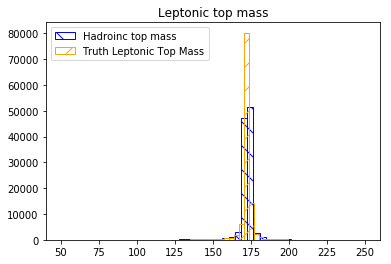

ValueError: range parameter must be finite.

In [96]:
import math
plt.hist([value for value in t_had_truth_mass if not math.isnan(value)] , bins =np.linspace(50,250,50), 
        hatch='\\',edgecolor='blue', fill=False,
        label="Hadroinc top mass")
plt.hist([value for value in t_lep_truth_mass if not math.isnan(value)],
        bins = 50,label="Truth Leptonic Top Mass", hatch='/',edgecolor = 'orange',fill=False)#s, bins = 50)#bins=np.linspace(50,250,))
plt.title("Leptonic top mass")
plt.legend()
plt.show()

plt.hist(w_had_mass, bins = np.linspace(50,350,50),label = "Hadroinc W mass",hatch='\\',fill = False,edgecolor='blue')
plt.hist(w_lep_mass, bins =np.linspace(50,350,50), label = "Reco Lep W mass", hatch='/',fill = False, edgecolor='orange')
plt.show()



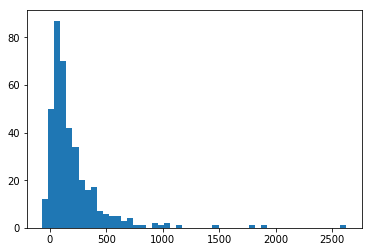

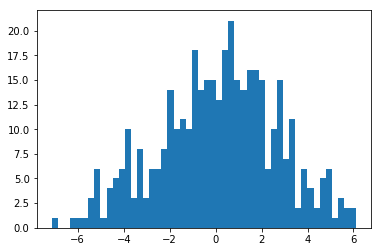

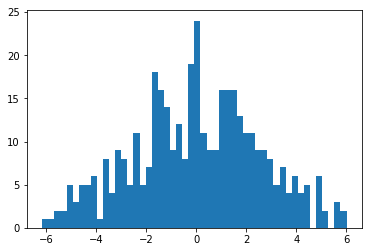

In [114]:
plt.hist(delta_had_m,bins=50)
plt.show()
plt.hist(delta_had_eta,bins=50)
plt.show()
plt.hist(delta_had_phi,bins=50)
plt.show()